In [1]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# defining function for dataLoading function
framObj = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [3]:
#len(os.listdir('/kaggle/input/deepglobe-road-extraction-dataset/train'))

In [4]:
#os.listdir('/kaggle/input/deepglobe-road-extraction-dataset/train')

In [5]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [6]:
from keras import backend as K

def IoU(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [7]:
def IoU_loss(y_true, y_pred):
    return -IoU(y_true, y_pred)

In [8]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = [IoU_loss], metrics = ['accuracy', IoU])

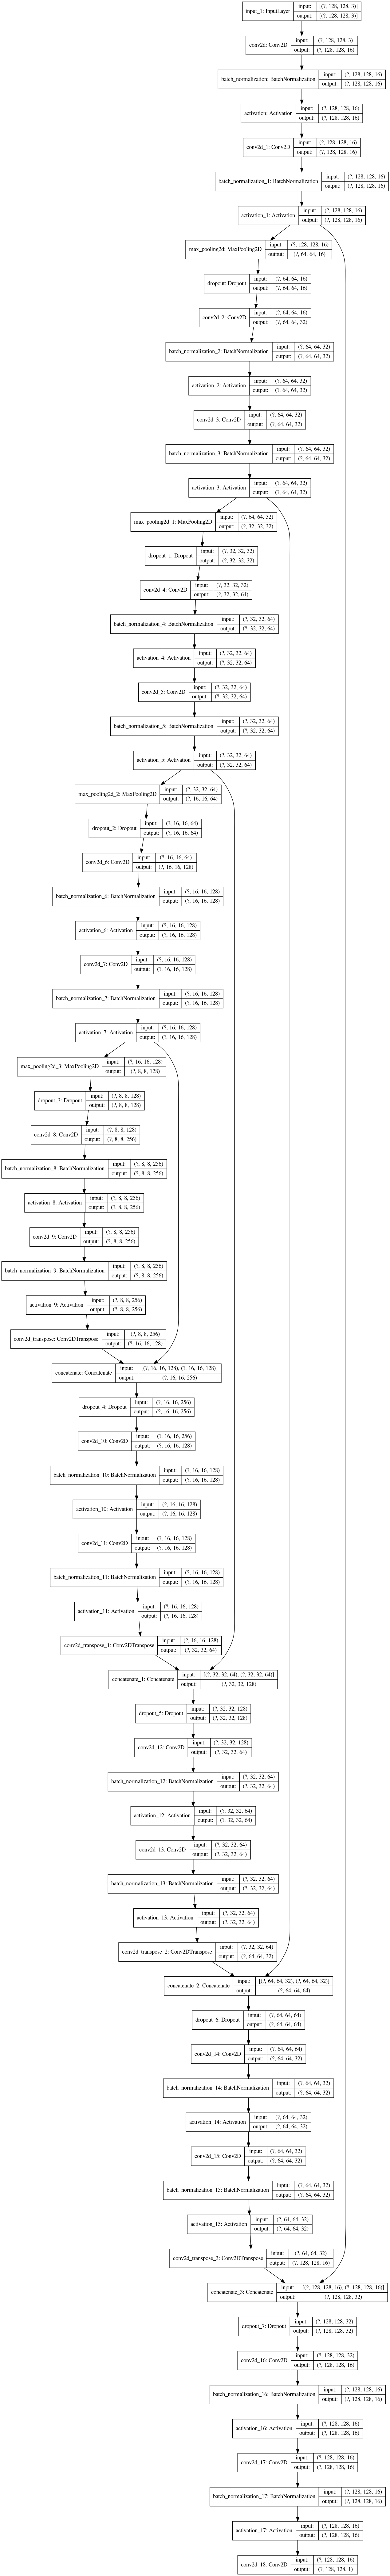

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [10]:
framObj = LoadData( framObj, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 256)

In [11]:
#len(framObj['mask'])

In [12]:
#print(framObj)

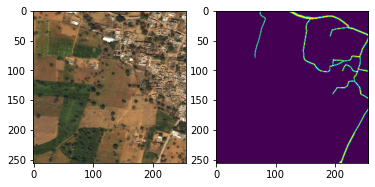

In [13]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObj['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObj['mask'][1])
plt.show()

In [14]:
#np.shape(np.array(framObj['img']))

In [15]:
#np.shape(np.array(framObj['img'])[:5300])

In [16]:
# x_train = np.array(framObj['img'])[:5300]
# y_train = np.array(framObj['mask'])[:5300]
# x_valid = np.array(framObj['img'])[5300:]
# y_valid = np.array(framObj['mask'])[5300:]

In [17]:
#x_valid, y_valid

In [18]:
#len(x_train)

In [19]:
#retVal = unet.fit(x_train, y_train, epochs = 10, verbose = 1)

In [20]:
retVal = unet.fit(np.array(framObj['img'])[:5300], np.array(framObj['mask'])[:5300], epochs = 50, verbose = 1)

Epoch 1/50
166/166 [==============================] - 35s 208ms/step - loss: -0.1284 - accuracy: 0.8075 - IoU: 0.1287
Epoch 2/50
166/166 [==============================] - 34s 204ms/step - loss: -0.3142 - accuracy: 0.9501 - IoU: 0.3143
Epoch 3/50
166/166 [==============================] - 34s 204ms/step - loss: -0.3967 - accuracy: 0.9595 - IoU: 0.3967
Epoch 4/50
166/166 [==============================] - 34s 204ms/step - loss: -0.4302 - accuracy: 0.9623 - IoU: 0.4302
Epoch 5/50
166/166 [==============================] - 34s 204ms/step - loss: -0.4495 - accuracy: 0.9639 - IoU: 0.4495
Epoch 6/50
166/166 [==============================] - 34s 204ms/step - loss: -0.4662 - accuracy: 0.9652 - IoU: 0.4662
Epoch 7/50
166/166 [==============================] - 34s 204ms/step - loss: -0.4775 - accuracy: 0.9661 - IoU: 0.4776
Epoch 8/50
166/166 [==============================] - 34s 204ms/step - loss: -0.4850 - accuracy: 0.9667 - IoU: 0.4849
Epoch 9/50
166/166 [==============================] - 34

In [21]:
#retVal = unet.fit(np.array(framObj['img'])[:5300], np.array(framObj['mask'])[:5300], epochs = 10, verbose = 1, validation_data=(np.array(framObj['img'])[5300:], np.array(framObj['mask'])[5300:]))

Text(0.5, 0, 'epochs')

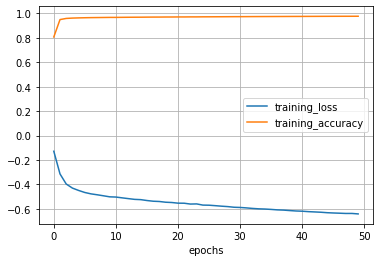

In [22]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')

Text(0, 0.5, 'IoU Score')

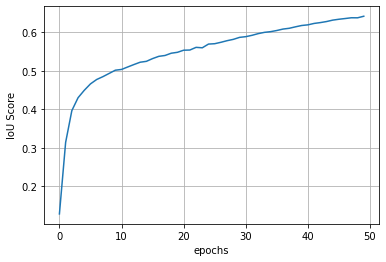

In [23]:
plt.plot(retVal.history['IoU'])
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('IoU Score') 

In [24]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    
  

In [25]:
sixteenPrediction, actuals, masks = predict16(framObj, unet)

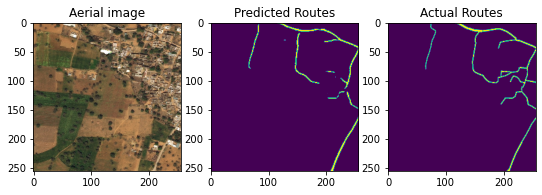

In [26]:
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

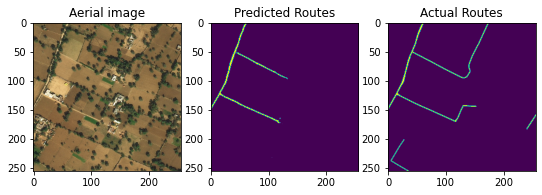

In [27]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

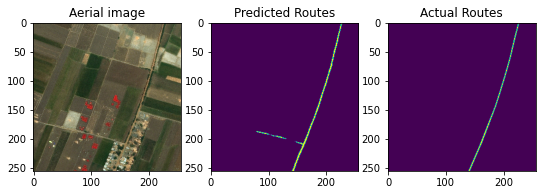

In [28]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

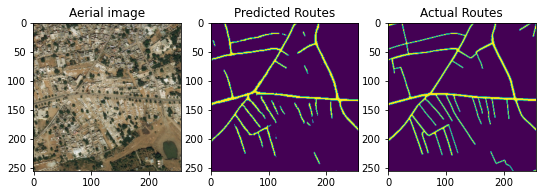

In [29]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

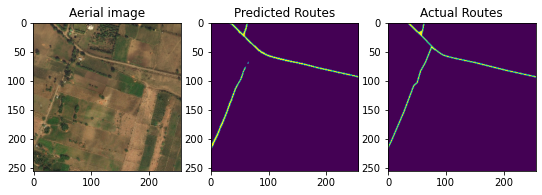

In [30]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

In [31]:
unet.save('RouteGenerator.h5')

In [32]:
a = 1